In [26]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('lib'))

import sig_proc as sp
import file_read

import csv

def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms

# For read maxim excel file
def maxm_reader(folder , source):
    for f in os.listdir(folder):
        if re.findall(source, f):
            ext = os.path.splitext(str(f))[-1].lower()
            if ext == '.csv':
                file_name = str(f)
                f_check = True
                break
            else:
                f_check = False

    if f_check:
        full_path = os.path.join(folder, file_name)
        reader = csv.reader(open(full_path))

        dataDict = []
        for i, row in enumerate(reader):
            if i == 6:
                first_row = row[:-1] #ignore last empty value
                dataDict = {r:[] for r in first_row}
            elif i > 6:
                if row[0] == 'stop time':
                    break
                for col in range(len(first_row)):
                    if row[col] == '':
                        _value = None
                    else:
                        _value = float(row[col])
                    dataDict[first_row[col]].append(_value)
        return dataDict
    else:
        raise Exception('File not found:{}'.format(file_path))

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data

def ppg_preprocess(ppg_data, sr, norm=1, flip=1):
    # band pass filter parameters
    b_b, b_a = sp.bp_filter(0.5, 10, sr, 4)
    
    if flip:
        ppg_flip = sp.flip_up_down(ppg_data)
    else:
        ppg_flip = ppg_data

    # band pass filter
    filtered_ppg = signal.filtfilt(b_b, b_a, ppg_flip)
    # filtered_ppg= sp.move_avg(filtered_ppg, 5)
    if norm:
        filtered_ppg = sp.z_score(filtered_ppg)
    return filtered_ppg

# Root mean square error
def rmse_calc(target, prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])

    squaredError = []

    for val in error:
        squaredError.append(math.sqrt(val**2))
    rmseError = np.mean(squaredError)
    print(rmseError)

# Mean absolute error
def mae_calc(target, prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])

    absError = []
    for val in error:
        absError.append(abs(val))#誤差絕對值
    maeError = np.mean(absError)
    print(maeError)


def spo2_calc(R_AC_component, R_DC_component, IR_AC_component, IR_DC_component, K1, K2):
    # RMS method
    R_divide = R_AC_component/R_DC_component
    R_RMS = RMS_amp(R_divide)

    IR_divide = IR_AC_component/IR_DC_component
    IR_RMS = RMS_amp(IR_divide)
    R_value = R_RMS/ IR_RMS
    
    return K1 + K2*R_value

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']                       
print('\n'.join(color for color in colors))       


#E24A33
#348ABD
#988ED5
#777777
#FBC15E
#8EBA42
#FFB5B8


,ID,R,IR,G
0,top,0.000171,0.000184,0.001011
1,bottom,0.000117,0.000349,0.000460
2,center,0.000099,0.000253,0.002567
3,finger,0.001370,0.003563,0.005669
4,ear,0.000714,0.000748,0.001794


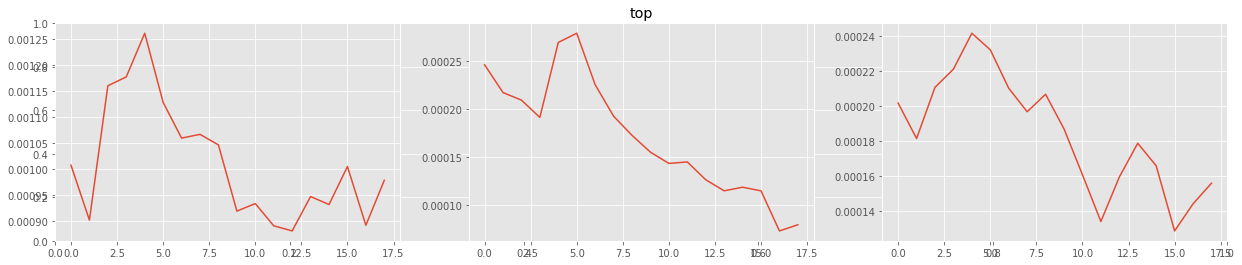

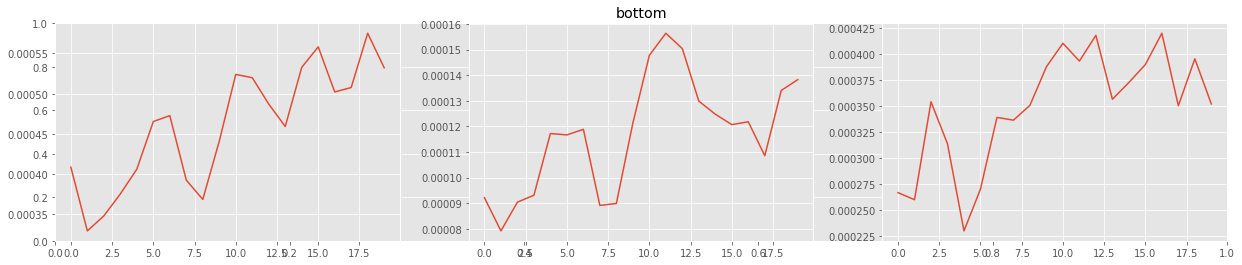

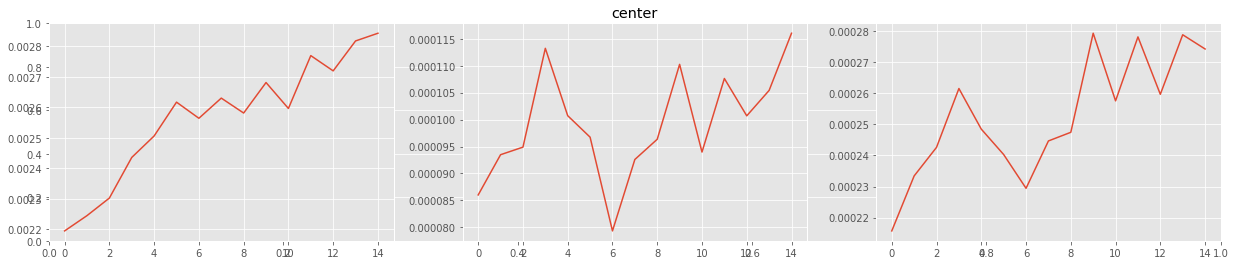

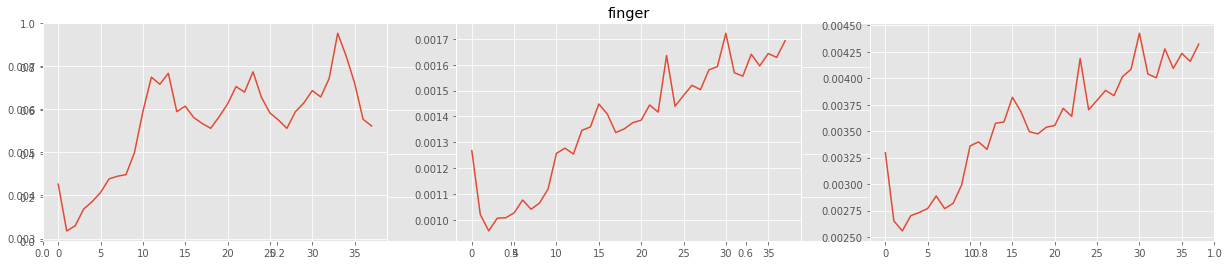

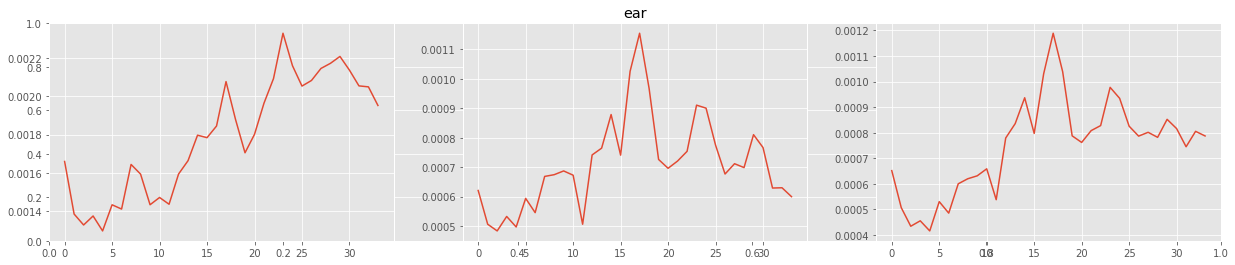

In [23]:

'''''''''''''''''''''''''''''''''''''''
Read Data 
'''''''''''''''''''''''''''''''''''''''
spo2_real = []

folder = '../data/86161'
# Regression parameter
K1 = 100.5
K2 = -19.2

sr = 200
acc_sr = 200

# source = 'finger'
source_ID = ['top', 'bottom', 'center', 'finger', 'ear']



''' Select the duration of PPG segment in seconds'''
window = 6 *sr
step_sec = 2
step = step_sec*sr


PI_table = {
    'ID':[],
    'R':[],
    'IR':[],
    'G':[]
}

R_PPG = { id:[] for id in source_ID}
IR_PPG = { id:[] for id in source_ID}
G_PPG = { id:[] for id in source_ID}

for id in source_ID:
    dataDict = maxm_reader(folder, id)
    G = dataDict['LEDC1']
    IR = dataDict['LEDC2']
    R = dataDict['LEDC3']
    G = np.array(G)
    IR = np.array(IR)
    R = np.array(R)
    
    windowNb = int((len(R)-window)/step) 

    R_PI = []
    IR_PI = []
    G_PI = []
    for n in range(5, windowNb):
        s1 = n*step
        s2 = s1 + window

        '''''''''''''''''''''''''''''''''''''''
        Signal Preprocessing
        '''''''''''''''''''''''''''''''''''''''
        IR_segment = np.array(IR[s1:s2])
        R_segment = np.array(R[s1:s2])
        G_segment= np.array(G[s1:s2])

        ''' Extract AC/DC '''
        R_AC = ppg_preprocess(R_segment, sr, norm=0, flip=0)
        IR_AC = ppg_preprocess(IR_segment, sr, norm=0, flip=0)
        G_AC = ppg_preprocess(G_segment, sr, norm=0, flip=0)

        R_PPG[id].append(R_AC)
        IR_PPG[id].append(IR_AC)
        G_PPG[id].append(G_AC)
        
        R_DC = sp.butter_lowpass_filter(R_segment, 5, sr, 4)  
        IR_DC = sp.butter_lowpass_filter(IR_segment, 5, sr, 4)
        G_DC = sp.butter_lowpass_filter(G_segment, 5, sr, 4)
        
        # RMS method
        R_PI.append(RMS_amp(R_AC/R_DC))
        G_PI.append(RMS_amp(G_AC/G_DC))
        IR_PI.append(RMS_amp(IR_AC/IR_DC))
        
        # Rvalue = R_PI/ IR_PI
        # spo2 =  K1 + K2*Rvalue
    fig = plt.figure(figsize = (21 ,4))
    plt.title(id)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.plot(G_PI)
    ax2.plot(R_PI)
    ax3.plot(IR_PI)
    
    PI_table['ID'].append(id)
    PI_table['R'].append(np.mean(R_PI))
    PI_table['IR'].append(np.mean(IR_PI))
    PI_table['G'].append(np.mean(G_PI))

        
        # plt.figure(figsize=(10,3))
        # plt.plot(R_AC)

PI_DATAFRAME = pd.DataFrame(PI_table)
PI_DATAFRAME



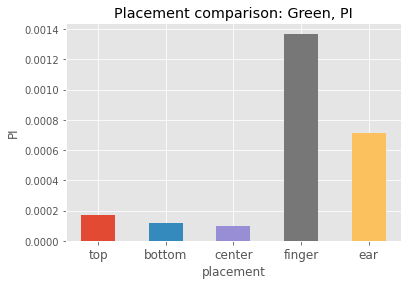

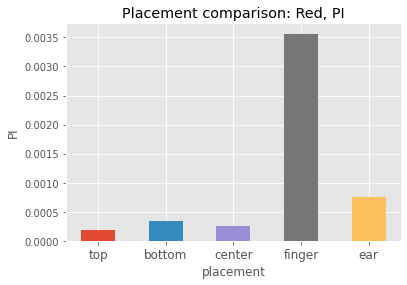

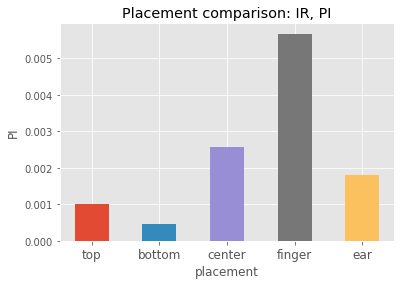

In [25]:
num_type = np.arange(len(source_ID))
plt.bar(num_type, PI_table['R'], width=0.5, bottom=None, align='center',
        color=[
            '#E24A33', 
            '#348ABD', 
            '#988ED5', 
            '#777777',
            '#FBC15E'])
plt.xticks(num_type, source_ID, fontsize=12)
plt.xlabel('placement')
plt.ylabel('PI')
plt.title('Placement comparison: Green, PI')
plt.show()

plt.figure()
plt.bar(num_type, PI_table['IR'], width=0.5, bottom=None, align='center',
        color=[
            '#E24A33', 
            '#348ABD', 
            '#988ED5', 
            '#777777',
            '#FBC15E'])
plt.xticks(num_type, source_ID, fontsize=12)
plt.xlabel('placement')
plt.ylabel('PI')
plt.title('Placement comparison: Red, PI')
plt.show()

plt.figure()
plt.bar(num_type, PI_table['G'], width=0.5, bottom=None, align='center',
         color=[
            '#E24A33', 
            '#348ABD', 
            '#988ED5', 
            '#777777',
            '#FBC15E'])
plt.xticks(num_type, source_ID, fontsize=12)
plt.xlabel('placement')
plt.ylabel('PI')
plt.title('Placement comparison: IR, PI')
plt.show()

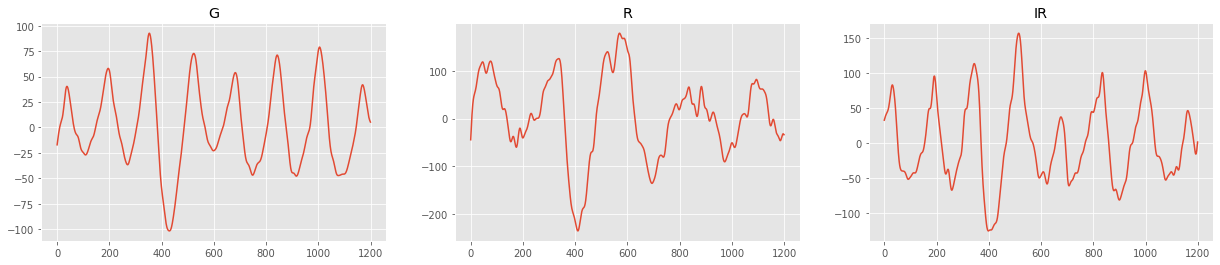

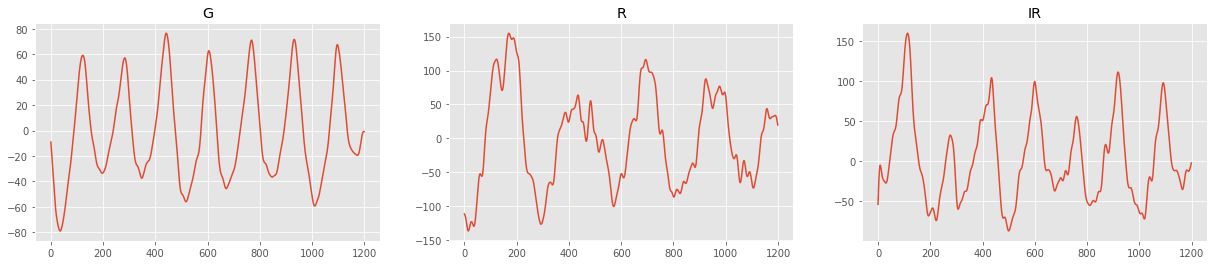

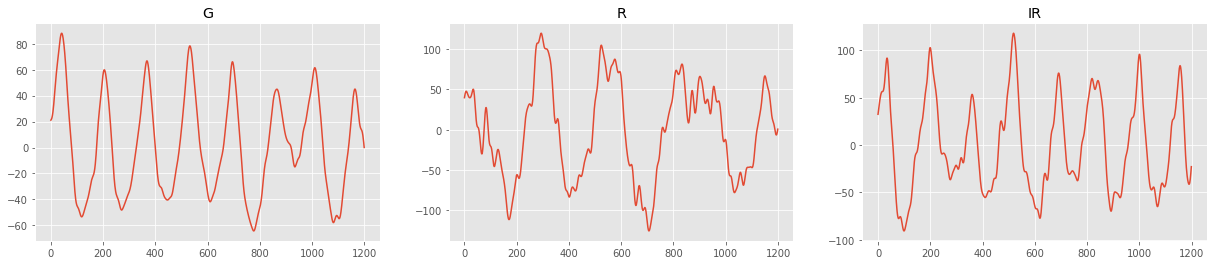

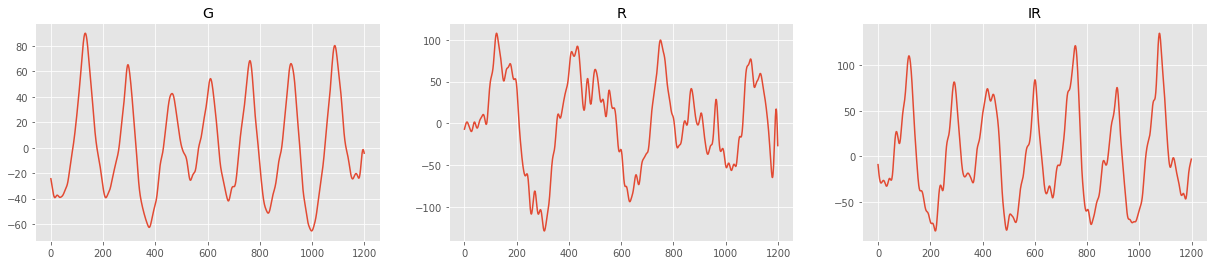

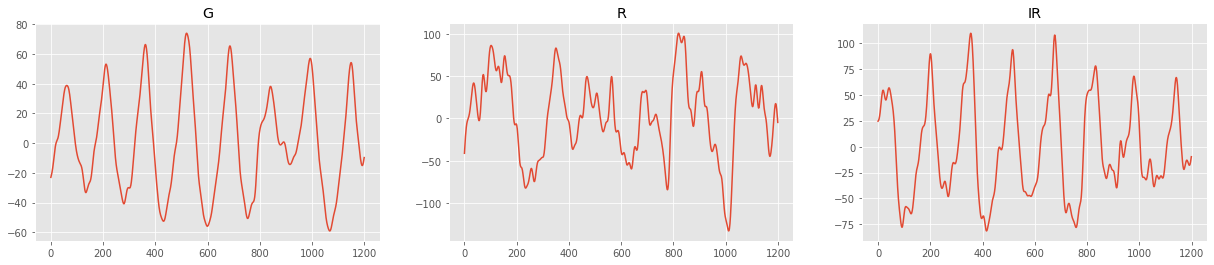

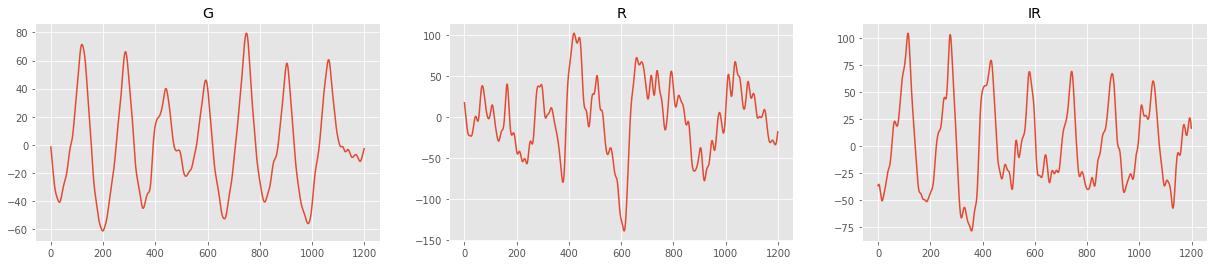

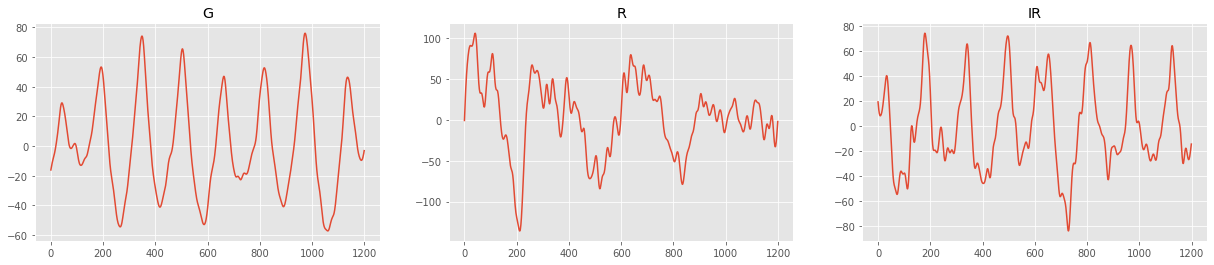

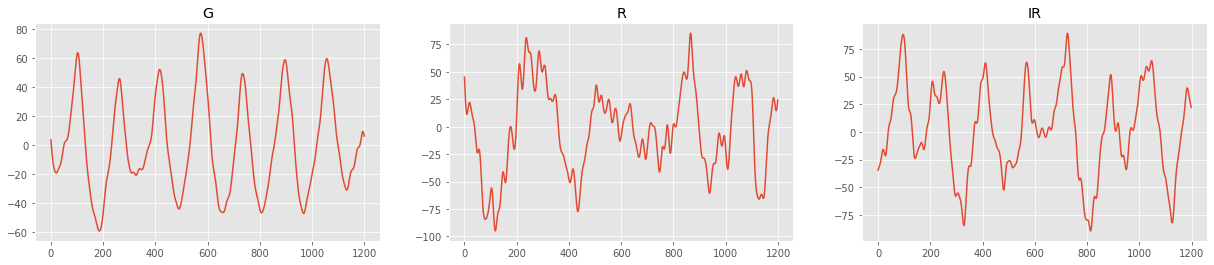

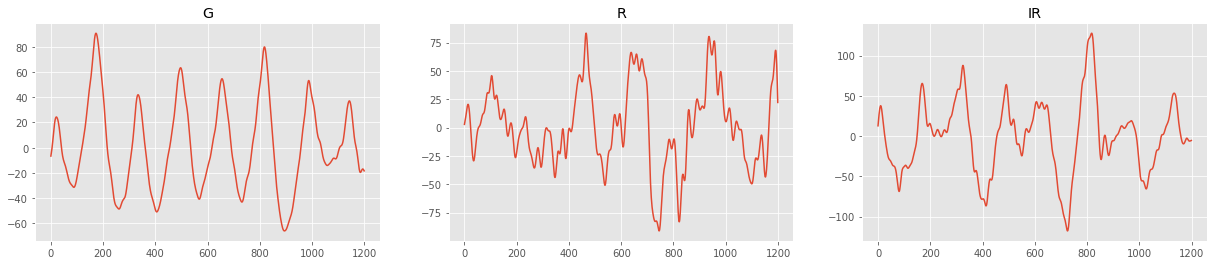

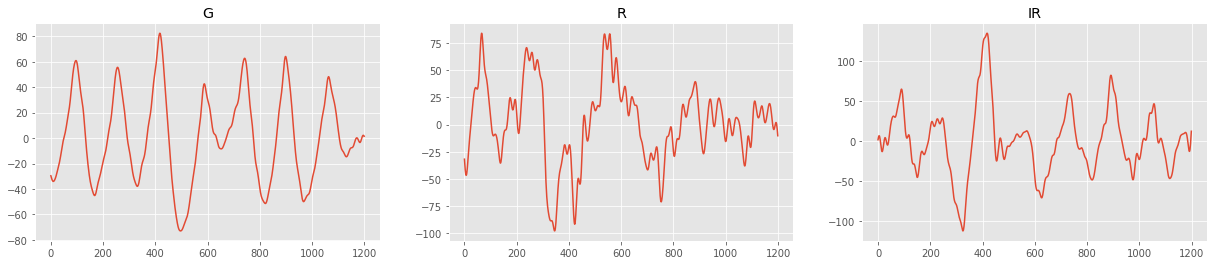

In [20]:
id = 'top'
for i in range(0, 10):
    fig = plt.figure(figsize = (21 ,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.plot(G_PPG[id][i])
    ax1.set_title('G')
    ax2.plot(R_PPG[id][i])
    ax2.set_title('R')
    ax3.plot(IR_PPG[id][i])
    ax3.set_title('IR')

In [16]:
len(G_PPG['center'])

10